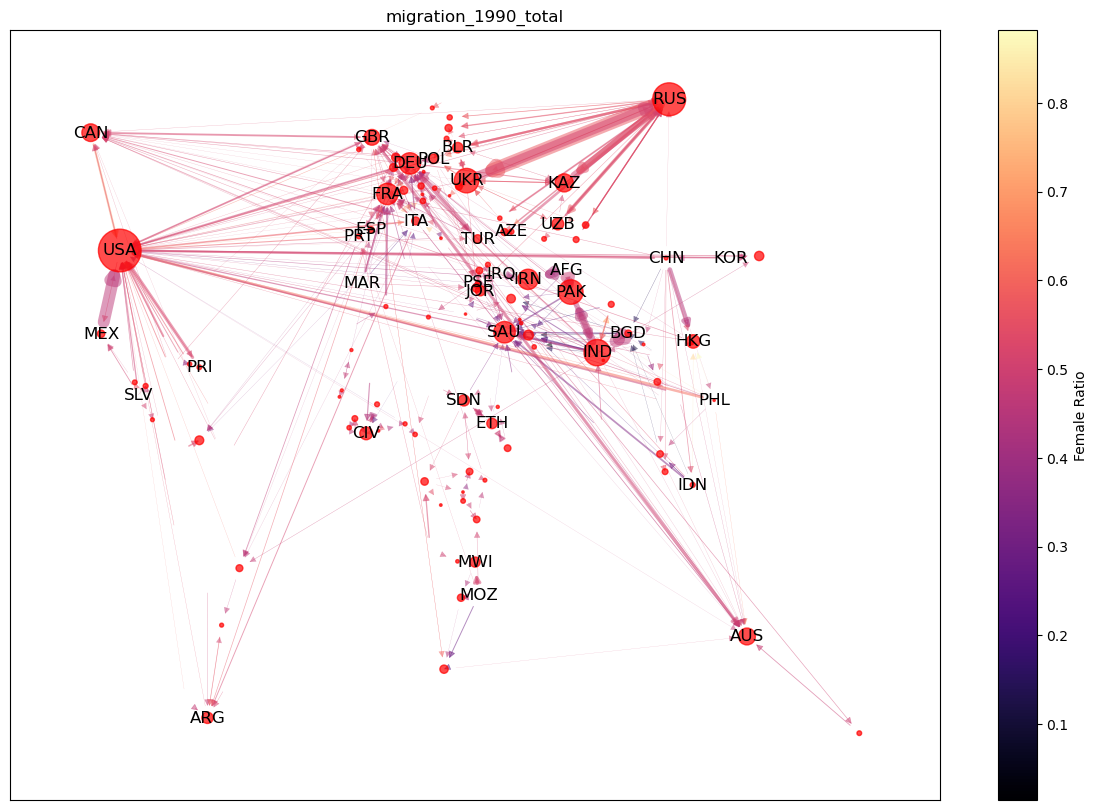

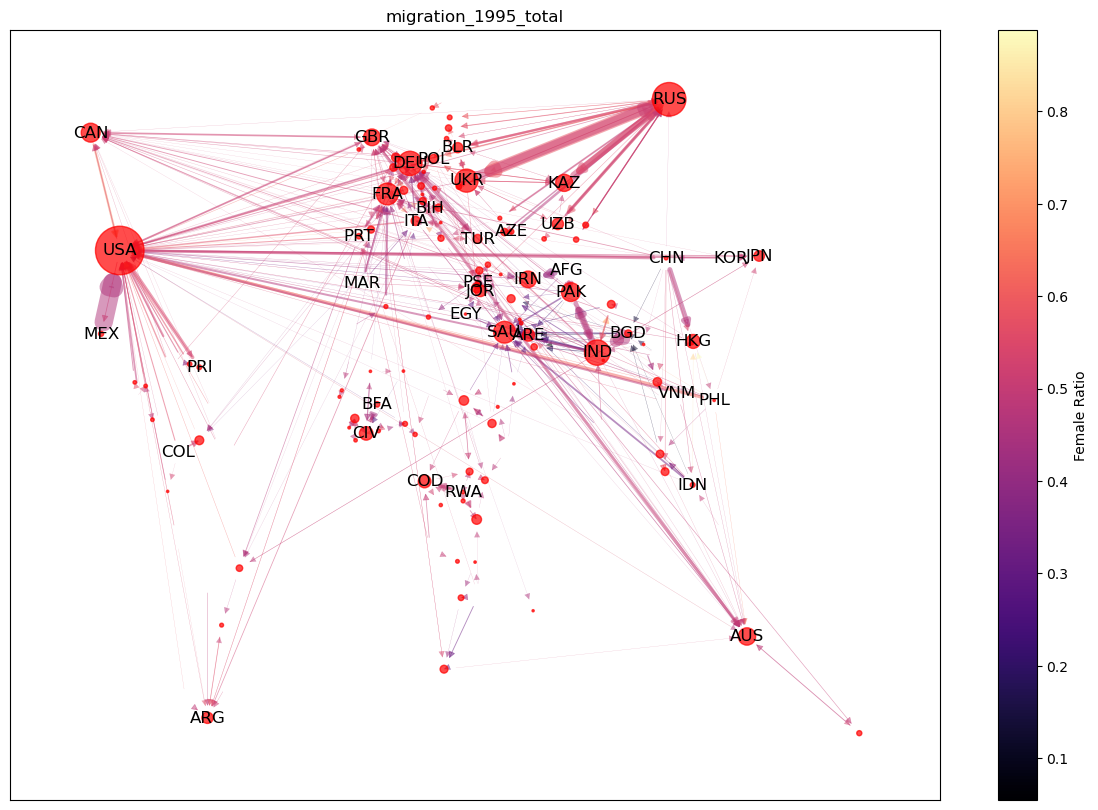

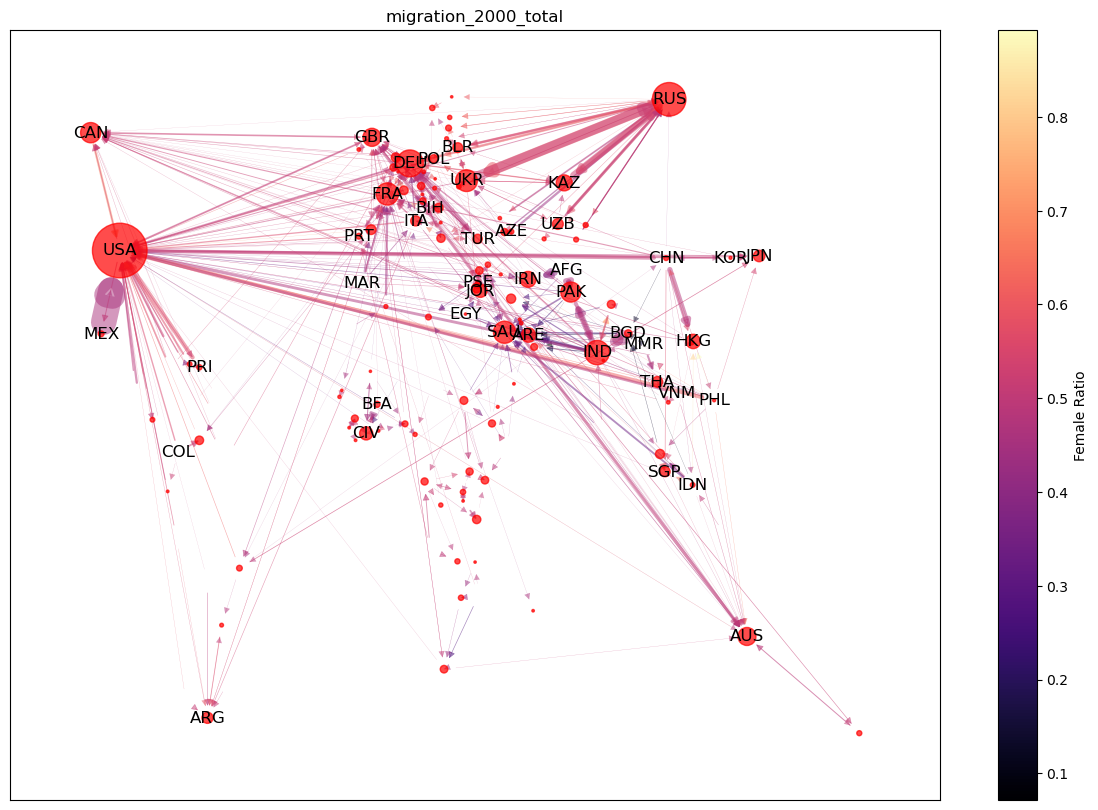

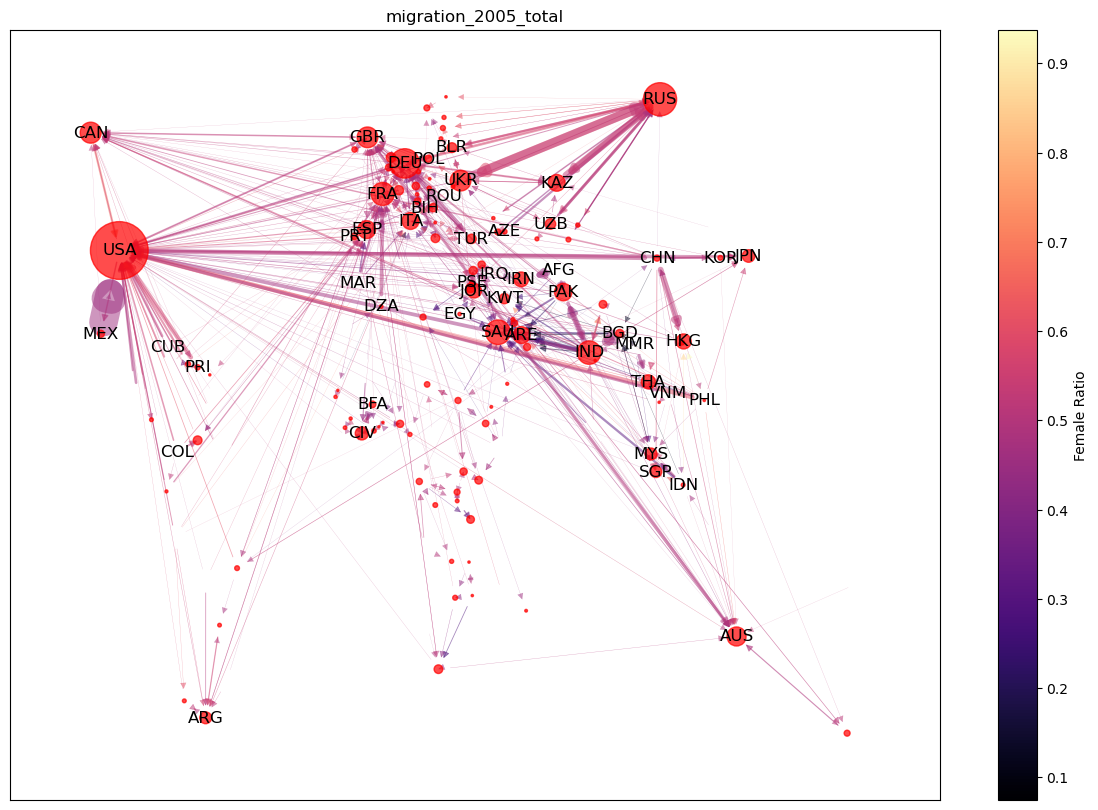

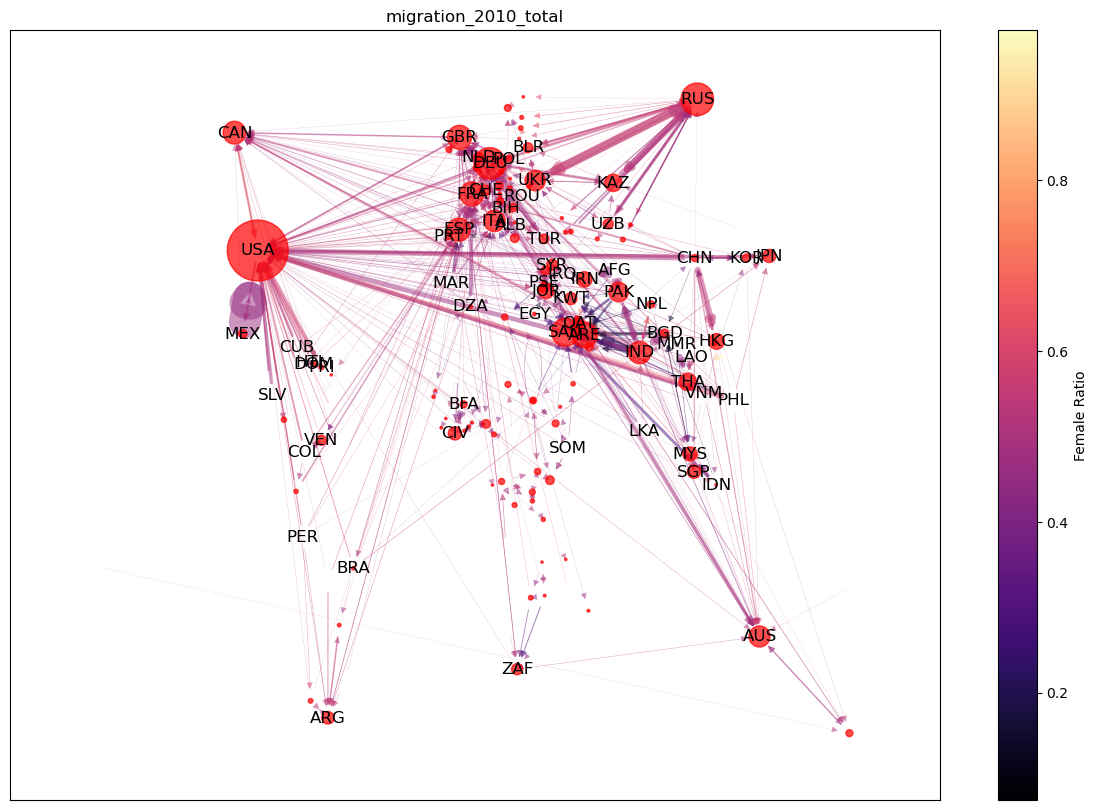

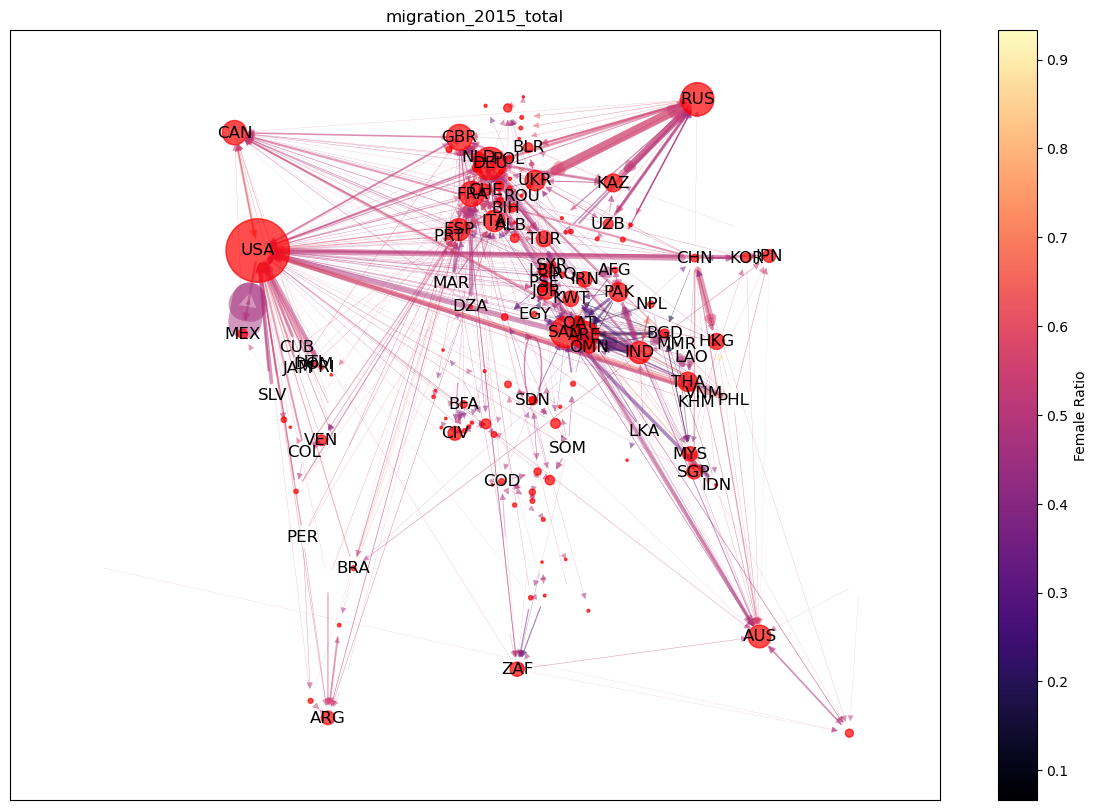

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import networkx as nx
import numpy as np
import pandas as pd

# Load the CSV file into a DataFrame
nodes_df = pd.read_csv('nodes.csv')
# Load the edges.csv file into a DataFrame
edges_df = pd.read_csv('edges.csv')

def create_graph(nodes_df, edges_df, migration_year):
    graph = nx.DiGraph()

    # Add nodes
    for index, row in nodes_df.iterrows():
        graph.add_node(row['Label'], name=row['Abb'])

    # Add edges with weights and attributes for the specific year
    for index, row in edges_df.iterrows():
        source = row['source']
        target = row['target']
        weight = row[migration_year]
        if weight != 0:
            female_ratio = row[migration_year.replace('total', 'female')] / weight
        else:
            female_ratio = 0
        graph.add_edge(source, target, weight=weight, female_ratio=female_ratio)

    # Clean up the graph (removing low weight edges and isolated nodes)
    remove_low_weight_edges(graph, 50000)
    remove_isolated_nodes(graph)
    return graph

def visualize_graph(graph, nodes_df, title):
    node_sizes = [graph.in_degree(n, weight='weight')/20000 for n in graph.nodes()]
    edge_weights = [d['weight'] / 500000 for _, _, d in graph.edges(data=True)]

    # Position, size, and labels
    node_positions = {row['Label']: (row['lng'], row['lat']) for index, row in nodes_df.iterrows() if row['Label'] in graph.nodes}
    labels = get_high_degree_labels(graph, nodes_df)

    # Edge colors based on female ratio
    female_ratios = np.array([d['female_ratio'] for _, _, d in graph.edges(data=True)])
    norm = mcolors.Normalize(vmin=female_ratios.min(), vmax=female_ratios.max())
    cmap = plt.get_cmap('magma')
    edge_colors = [cmap(norm(d['female_ratio'])) for _, _, d in graph.edges(data=True)]

    # Visualization
    plt.figure(figsize=(15, 10))
    nx.draw_networkx_nodes(graph, node_positions, node_size=node_sizes, node_color='red', alpha=0.7)
    nx.draw_networkx_edges(graph, node_positions, width=edge_weights, alpha=0.5, edge_color=edge_colors)
    nx.draw_networkx_labels(graph, node_positions, labels=labels, font_size=12)
    plt.title(title)
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=plt.gca(), orientation='vertical', label='Female Ratio')
    plt.show()

def remove_low_weight_edges(graph, threshold):
    edges_to_remove = [(u, v) for u, v, d in graph.edges(data=True) if d['weight'] < threshold]
    graph.remove_edges_from(edges_to_remove)

def remove_isolated_nodes(graph):
    nodes_to_remove = [n for n in graph.nodes() if graph.degree(n) == 0]
    graph.remove_nodes_from(nodes_to_remove)

def get_high_degree_labels(graph, nodes_df):
    return {n: data['Abb'] for n, data in nodes_df.set_index('Label').iterrows() 
            if n in graph.nodes() and (graph.in_degree(n, weight='weight') > 1000000 or graph.out_degree(n, weight='weight') > 1000000)}

# Main execution loop for each migration year
migration_years = ['migration_1990_total', 'migration_1995_total', 'migration_2000_total', 'migration_2005_total', 'migration_2010_total', 'migration_2015_total']
graphs =[]
for year in migration_years:
    # Create a separate graph for each year and store it in a dictionary
    graph = create_graph(nodes_df, edges_df, year)
    # Visualize the graph
    visualize_graph(graph, nodes_df, year)
    graphs.append(graph)

(array([364.,  27.,   5.,   3.,   2.,   1.,   3.,   0.,   2.,   1.]),
 array([  50041. ,  546846.7, 1043652.4, 1540458.1, 2037263.8, 2534069.5,
        3030875.2, 3527680.9, 4024486.6, 4521292.3, 5018098. ]),
 <BarContainer object of 10 artists>)

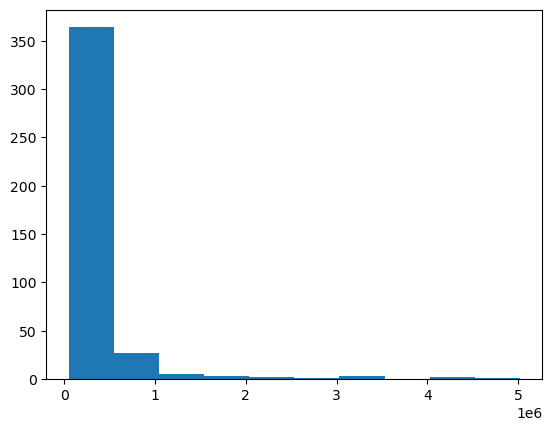

In [3]:
# checking the distribution of weights in the first graph
weights = [d['weight'] for _, _, d in graphs[0].edges(data=True)]
plt.hist(weights, bins=10)

In [4]:
# checking the statistics of the weights in the first graph
pd.Series(weights).describe()

count    4.080000e+02
mean     2.921637e+05
std      5.521227e+05
min      5.004100e+04
25%      7.686775e+04
50%      1.326690e+05
75%      2.538432e+05
max      5.018098e+06
dtype: float64

In [ ]:
# adding the latitude and longitude attributes to the nodes
for graph in graphs:
    for node in graph.nodes():
        graph.nodes[node]['lat'] = nodes_df.loc[nodes_df['Label'] == node]['lat'].values[0]
        graph.nodes[node]['lng'] = nodes_df.loc[nodes_df['Label'] == node]['lng'].values[0]

In [ ]:
# saving the second graph to a ghraphml file
nx.write_graphml(graphs[1], "graph_1995.graphml")
